# Modelo de Predicción de Estado de Impago Financiero
*por Javier Jiménez*

## Introducción

Un deudor puede declararse en impago cuando no es capaz de hacer el pago requerido o no está dispuesto a pagar esa deuda. Por tanto, el default financiero se produce cuando un deudor no puede cumplir con la obligación legal de pagar su deuda.

La incapacidad de las personas de pagar podría deberse a diferentes circunstancias. Sin embargo, cuando es deliberado, lo que significa que los clientes no tienen planes de devolverle el dinero al banco, se consideraría un fraude. De cualquier manera, esto impone un gran riesgo a las compañías y  encontrar una manera de identificarlo es importante.

## Objetivos: 
1. Desarrollar un Modelo para calcular

* La Probabilidad de Impago (Default) de un cliente [Variable Continua: 0.0 1.0\]

* El estatus de default [variable Binaria: Si=1, o No=0\]

2. Estimar el monto total (en unidad de dinero) de la cartera en perdida.

## Dataset:
default_dataset.csv

## Contenido

1. Librerias

2. Cargando los Datos

3. Limpieza de Datos

4. Exploración de Datos

5. Ingeniería de Características

6. Selección de Modelo

 6.1 Random Forest

 6.2 Evaluación

7. Estimación del Monto Total de la Cartera en Perdida

 7.1 Creando el Dataset: validation_dataset.csv

 7.2 Predicción y Probabilidad de Impago
 
8. Concluciones

---

## 1. Librerias

In [1]:
# Importando librerias
import numpy as np
import pandas as pd
import scipy.stats as stats
from scipy.stats import randint as sp_randint

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import plotly.io as pio
import plotly.figure_factory as ff 

from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, precision_score, roc_auc_score,roc_curve,classification_report
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.utils import resample
from imblearn import under_sampling 
from imblearn import over_sampling
from imblearn.over_sampling import SMOTE

import joblib
import warnings
warnings.filterwarnings("ignore")


## 2. Cargando los Datos

In [2]:
# Almacenar los datos en un Dataframe
df = pd.read_csv("default_dataset.csv")
print("listo")

listo


## 3. Limpieza de Datos

Se solicitan las dimensiones del dataframe para tener en cuenta la cantidad de datos.

In [3]:
print("default_dataset -  filas:",df.shape[0]," columnas:", df.shape[1])

default_dataset -  filas: 27999  columnas: 25


Se solicita una pequeña muestra para tener una idea del aspecto de los datos y revisar que el dataframe esté en orden.

In [4]:
df.sample(3)

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
8302,4707,210000,2,2,1,32,-1,-1,-1,-1,...,407,737,407,737,737,407,737,407,1232,0
25403,26670,200000,1,1,2,33,0,0,0,0,...,68085,69445,71242,2387,2485,2414,2434,2863,3000,0
14364,12544,80000,2,3,2,28,0,0,0,0,...,66876,66182,67199,3500,2600,2400,2500,2700,2300,0


Se solicita un resumen conciso de los datos para identificar si existen anormalidades en estos. Esto con la meta de posteriormente realizar las correcciones debidas de ser necesario y obtener un dataframe "limpio" y fácil de manipular.

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27999 entries, 0 to 27998
Data columns (total 25 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   ID         27999 non-null  int64
 1   LIMIT_BAL  27999 non-null  int64
 2   SEX        27999 non-null  int64
 3   EDUCATION  27999 non-null  int64
 4   MARRIAGE   27999 non-null  int64
 5   AGE        27999 non-null  int64
 6   PAY_0      27999 non-null  int64
 7   PAY_2      27999 non-null  int64
 8   PAY_3      27999 non-null  int64
 9   PAY_4      27999 non-null  int64
 10  PAY_5      27999 non-null  int64
 11  PAY_6      27999 non-null  int64
 12  BILL_AMT1  27999 non-null  int64
 13  BILL_AMT2  27999 non-null  int64
 14  BILL_AMT3  27999 non-null  int64
 15  BILL_AMT4  27999 non-null  int64
 16  BILL_AMT5  27999 non-null  int64
 17  BILL_AMT6  27999 non-null  int64
 18  PAY_AMT1   27999 non-null  int64
 19  PAY_AMT2   27999 non-null  int64
 20  PAY_AMT3   27999 non-null  int64
 21  PAY_AMT4   2

Se asegura de que no falte algún dato en el dataframe.

In [6]:
#Consultar si existe algún valor nulo en el dataset
df.isnull().values.any()

False

Se revisan las variables categoricas.

In [7]:
#Solicitar la cantidad de categorias por variable
df[['SEX', 'EDUCATION', 'MARRIAGE']].nunique()

SEX          2
EDUCATION    7
MARRIAGE     4
dtype: int64

Debido a que el nombre de estas categorias aparecen indocumentadas, no es posible dictar si hay anomalias en estas. Se trabajarán con las que se encuentran actualmente.

Al revisar la información, no se encontraron anomalias. Los datos están limpios y son adecuados para trabajar.

## 4. Exploración de Datos

Se exploran a más detalle los datos.

In [8]:
df.describe()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
count,27999.000000,27999.000000,27999.000000,27999.000000,27999.000000,27999.000000,27999.000000,27999.000000,27999.000000,27999.000000,...,27999.000000,27999.000000,27999.000000,27999.000000,2.799900e+04,27999.000000,27999.000000,27999.000000,27999.000000,27999.000000
mean,15749.304368,169647.833137,1.607522,1.853888,1.552484,35.484696,-0.063324,-0.169327,-0.201900,-0.248009,...,43501.129397,40427.848780,38988.426658,5823.589878,6.107637e+03,5383.826137,4951.663381,4878.592700,5342.790350,0.165613
std,8452.091410,130240.416104,0.488311,0.795310,0.521850,9.168462,1.088628,1.162094,1.158822,1.139461,...,64547.035637,60932.675754,59691.059489,16926.065931,2.362333e+04,17997.627313,16023.404493,15329.242967,17990.023991,0.371740
min,3.000000,10000.000000,1.000000,0.000000,0.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,...,-170000.000000,-81334.000000,-209051.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,8999.500000,60000.000000,1.000000,1.000000,1.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,2373.000000,1809.000000,1278.000000,1000.000000,1.000000e+03,457.000000,316.000000,298.500000,188.000000,0.000000
50%,15999.000000,140000.000000,2.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,...,19097.000000,18106.000000,17021.000000,2184.000000,2.078000e+03,1917.000000,1520.000000,1548.000000,1500.000000,0.000000
75%,22998.500000,240000.000000,2.000000,2.000000,2.000000,41.000000,0.000000,0.000000,0.000000,0.000000,...,55154.500000,50437.500000,49380.000000,5100.000000,5.000000e+03,4730.000000,4162.000000,4181.500000,4133.500000,0.000000
max,30000.000000,1000000.000000,2.000000,6.000000,3.000000,79.000000,8.000000,8.000000,8.000000,8.000000,...,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.000000,621000.000000,426529.000000,528666.000000,1.000000


* Existen 27999 clientes distintos.

* El valor promedio del límite de balance es de 169,647.8.

* La edad media es de 35.5 años, con una desviación estándar de 9.2.

* Como el valor 0 para el pago predeterminado significa 'no impago' y el valor 1 significa 'impago', la media de 0.165 significa que hay un 16.5% de los contratos que se impagarán.

Se grafican los valores de cada columna comparados con el impago para encontrar relaciones en estas.

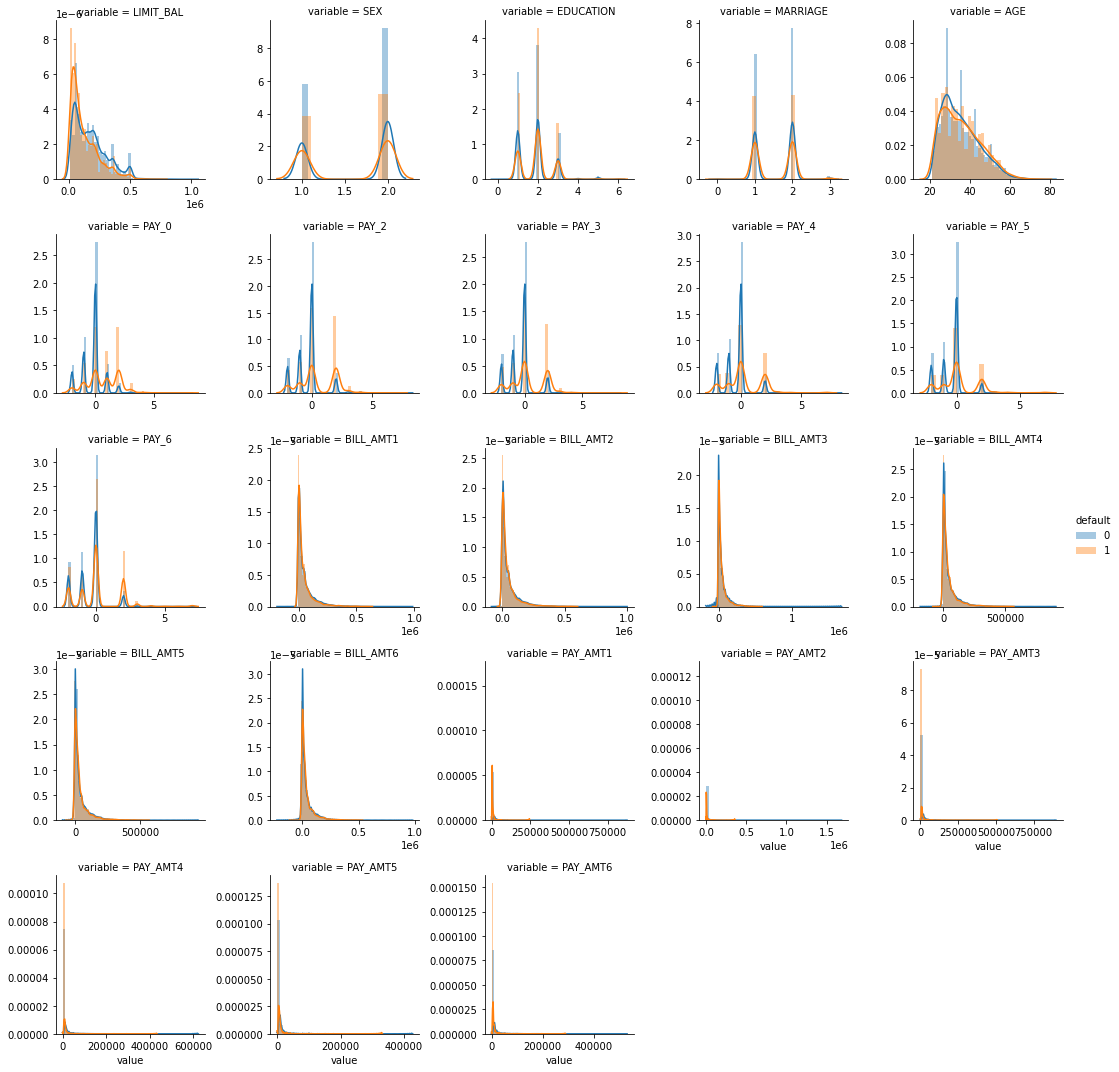

In [9]:
output = 'default'

cols = [ f for f in df.columns if df.dtypes[ f ] != "object"]
cols.remove( "ID")
cols.remove( output )

f = pd.melt( df, id_vars=output, value_vars=cols)
g = sns.FacetGrid( f, hue=output, col="variable", col_wrap=5, sharex=False, sharey=False )
g = g.map( sns.distplot, "value", kde=True).add_legend()

* Aquellos clientes con los LIMIT_BAL más bajos tienen un impago más alto.

* Los no incumplidos tienen una mayor proporción de personas de 30 a 40 años.

* Los que no impagan tienen una proporción mucho más alta de variables PAY_X. Esta es una relación sólida ya que la distribución está más separada, por lo que se espera que las variabbles PAY_X sean importantes.

Se verifica la distribución del limite de balance vs sexo.

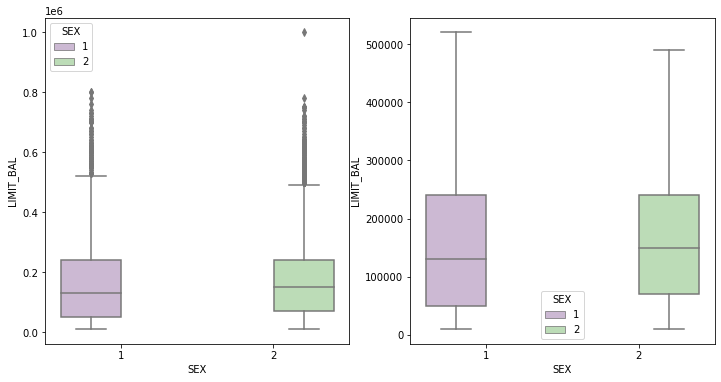

In [10]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12,6))
s = sns.boxplot(ax = ax1, x="SEX", y="LIMIT_BAL", hue="SEX",data=df, palette="PRGn",showfliers=True)
s = sns.boxplot(ax = ax2, x="SEX", y="LIMIT_BAL", hue="SEX",data=df, palette="PRGn",showfliers=False)
plt.show()

El monto del crédito límite está bastante equilibrado entre sexos.

Se visualizan las correlaciones del dataset.

<AxesSubplot:>

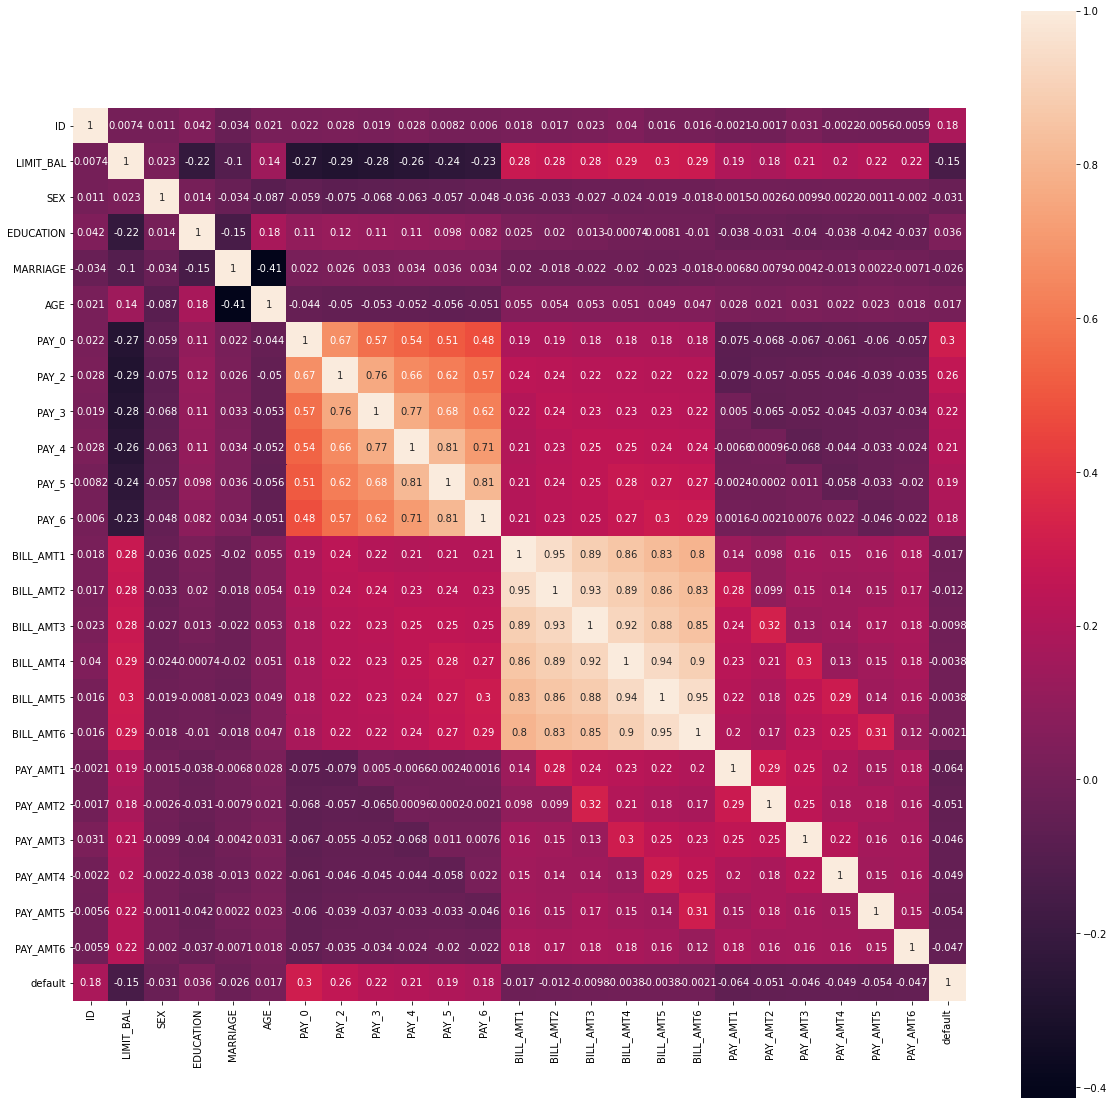

In [11]:
plt.figure(figsize = (20,20))
sns.heatmap(df.corr(),annot = True,square = True)

Es una visualización de correlación interesante. Se muestra que las características como PAY_0,2,3,4,5,6 y BILL_AMT1,2,3,4,5,6 estan correlacionadas entre si. Parece que las variables PAY_X son los predictores más fuertes de valores de impago.

## 5. Ingeniería de Características

Se procede a implementar One Hot Encoding. Este es un proceso mediante el cual las variables categóricas son convertidas de una forma que puede proporcionarse a un algoritmo de ML para obtener un mejor desempeño en la predicción.

In [12]:
df[['SEX','MARRIAGE','EDUCATION']] = df[['SEX','MARRIAGE','EDUCATION']].astype('object')

#One Hot encoding
df = pd.get_dummies(df)
df.head()

,ID,LIMIT_BAL,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,...,EDUCATION_1,EDUCATION_2,EDUCATION_3,EDUCATION_4,EDUCATION_5,EDUCATION_6,MARRIAGE_0,MARRIAGE_1,MARRIAGE_2,MARRIAGE_3
0,8920,50000,23,2,3,2,0,0,0,7557,...,1,0,0,0,0,0,0,0,1,0
1,8926,20000,51,0,0,0,0,2,2,14341,...,0,0,1,0,0,0,0,1,0,0
2,8930,10000,29,2,2,2,2,3,2,5833,...,0,1,0,0,0,0,0,0,1,0
3,8933,240000,42,1,2,2,0,0,0,187558,...,0,1,0,0,0,0,0,0,1,0
4,8938,170000,30,2,0,0,0,0,0,27267,...,1,0,0,0,0,0,0,0,1,0


El dataset final está terminado, se procede a dividir el conjunto de datos en una proporción de 70:30 (70% entrenamieto, 30% validación) para entrenar y probar.

In [13]:
X = df.drop(['default','ID'], axis=1) # Características. Se elimina ID ya que este factor no afecta significativamente la calidad de un cliente.
y = df['default'] # objetivo

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, stratify=y, random_state=42)

Se crea un dataset de entrenamiento.

In [14]:
# Se unen X_train y y_train para crear este nuevo dataset
df_train = X_train.join(y_train)

Se consulta la distribución de las muestras en el conjunto de datos de entrenamieto.

In [15]:
# Se separan las clases de mayoría y minoría
df_majority = df_train[df_train.default == 0]
df_minority = df_train[df_train.default == 1]

print(df_majority.default.count())
print("-----------")
print(df_minority.default.count())
print("-----------")
print(df_train.default.value_counts())

16353
-----------
3246
-----------
0    16353
1     3246
Name: default, dtype: int64


Se puede notar que hay mucho desequilibrio en la muestra. Lo más probable es que mi modelo prediga que la mayoría de los clientes pertenecen a la clase mayoritaria (no impagantes, en este caso). En estos casos se pueden utilizar tecnicas de remuestreo. El remuestreo implica la creación de una nueva versión transformada del conjunto de datos de entrenamiento en la que los ejemplos seleccionados tienen una distribución de clases diferente. Ésta es una estrategia simple y efectiva para problemas de clasificación desequilibrada. Si bien podría tomar una muestra inferior de la clase mayoritaria, resultará en la pérdida de grandes cantidades de datos dado el margen de cuánto la clase mayoritaria supera a la minoría.

SMOTE crea un sobremuestreo basado en aprendizaje automático que, en este caso, creará registros duplicados bastante similares entre sí, lo que permitirá agregar más muestras a la clase minoritaria.

In [16]:
# Utilizando SMOTE para arreglar el desequilibrio
sm = SMOTE(random_state=42)
X_SMOTE, y_SMOTE = sm.fit_sample(X_train, y_train)
print(len(y_SMOTE))
print(y_SMOTE.sum())

32706
16353


Por último, se define una función que evalua el modelo con puntajes de entrenamiento y prueba y ejecuta una K-fold cross validation en el dataset de entrenamiento.

In [17]:
def model_eval(algo, Xtrain,ytrain,Xtest,ytest):

    algo.fit(Xtrain,ytrain)
    y_pred = algo.predict(Xtrain)
    y_train_prob = algo.predict_proba(Xtrain)[:,1]

    print('Precisión General de Entrenamieto ',accuracy_score(ytrain,y_pred))
    print('Puntuación AUC de Entrenamiento ',roc_auc_score(ytrain,y_train_prob))

    y_test_pred = algo.predict(Xtest)
    y_test_prob = algo.predict_proba(Xtest)[:,1]

    print('Precisión General de Prueba ',accuracy_score(ytest,y_test_pred))
    print('Puntuación AUC de Prueba ',roc_auc_score(ytest,y_test_prob))
    print('Reporte de Clasificación de la Prueba \n',  classification_report(ytest, y_test_pred))
    
    
    kf = KFold(n_splits = 5,shuffle = True,random_state = 42)
    score=[]
    for train_idx,test_idx in kf.split(Xtrain,ytrain):
        xtrain_k,xtest_k = Xtrain.iloc[train_idx,:],Xtrain.iloc[test_idx,:]
        ytrain_k,ytest_k = ytrain.iloc[train_idx],ytrain.iloc[test_idx]
        algo.fit(xtrain_k,ytrain_k)
        y_pred_k = algo.predict(xtest_k)
        roc = roc_auc_score(ytest_k,y_pred_k)
        score.append(roc)
    print('Puntuación K-Fold: %0.03f (+/- %0.5f)' % (np.mean(score),np.var(score,ddof=1)))
    
    f,ax =  plt.subplots(1,2,figsize=(14,6))
    ConfMatrix = confusion_matrix(ytest,y_test_pred)
    sns.heatmap(ConfMatrix,annot=True, cmap='YlGnBu', fmt="d", 
            xticklabels = ['Non-default', 'Default'], 
            yticklabels = ['Non-default', 'Default'],linewidths=.5,ax = ax[0])
    ax[0].set_ylabel('Clasificación Verdadera')
    ax[0].set_xlabel('Clasificación Predecida')
    ax[0].set_title('Confusion Matrix')

    global fpr,tpr,thresholds
    fpr,tpr,thresholds = roc_curve(ytest,y_test_prob)
    ax[1].plot(fpr,tpr,color = 'r')
    ax[1].plot(fpr,fpr,color = 'green')
    ax[1].set_ylabel('True Positive Rate')
    ax[1].set_xlabel('False Positive Rate')
    ax[1].set_title('ROC - AUC Curve')
    plt.show()

## 6. Selección de Modelo

Si el interés de un banco es predecir el impago de sus clientes, podría ser mejor utilizar un modelo menos inclinado a devolver falsos negativos. Sin embargo, si el banco esta interesado en invertir recursos para evitar el incumplimiento de sus clientes, los falsos positivos seran más relevantes. En este caso se buscara crear un modelo con menos inclinación a los falsos negativos.

### 6.1 Random Forest

Este es un problema de clasificación y esto significa que los siguientes algoritmos son validos para la creación de un modelo:


* Regresión logística
* Naive Bayes
* K-Nearest Neighbours
* Decision Tree
* Random Forest
* Entre otros...

Sin embargo, el árbol es muy fácil de usar e imaginar, puede manejar tanto variables numéricas como categóricas, pero es fácil caer en el overfitting (es decir, crear un modelo muy complejo que describe perfectamente su conjunto de entrenamiento pero falla en la predicción). También se dice que es sensible a pequeños cambios en los datos, lo que lleva a resultados diferentes. Por este motivo, es habitual utilizar conjuntos como Random Forest para evitar este riesgo.

Los principales beneficios del Random Forest son:
* Es muy fácil medir la importancia relativa de cada característica en la predicción.
* Tiene casi los mismos hiperparámetros que un árbol de decisión.
* Agrega aleatoriedad adicional al modelo, mientras hace crecer sus árboles.

Uno de los mayores problemas del aprendizaje automático es el overfitting, pero la mayoría de las veces esto no sucederá gracias al clasificador de Random Forest. Si hay suficientes árboles en el bosque, el clasificador no se ajustará demasiado al modelo.


Se encuentran los mejores parametros para el dataset.

In [18]:
xtrain_data = X_SMOTE
ytrain_data = y_SMOTE

global best_rf
best_rf =[]

rfc = RandomForestClassifier(random_state = 42)

    # Configurar los parámetros y distribuciones para muestrear desde: param_dist
params = {'n_estimators' : sp_randint(50,200),
              'max_features' : sp_randint(1,24),'max_depth': sp_randint(2,10),
             'min_samples_leaf':sp_randint(1,20),
             'min_samples_split':sp_randint(2,20),
             'criterion':['gini','entropy']}

    # Instanciar el objeto RandomizedSearchCV
rsearch_rfc = RandomizedSearchCV(rfc, param_distributions= params, cv = 5,verbose=2, scoring = 'roc_auc', n_iter = 200,random_state = 42, n_jobs = -1, return_train_score = True)

    # Fit it to the data
rsearch_rfc.fit(xtrain_data,ytrain_data)
best_rf.append(rsearch_rfc.best_params_)
print("Tuned Random Tree Parameters: {}".format(rsearch_rfc.best_params_), "con SMOTE") 
print("_" * 100)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  7.4min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed: 21.0min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed: 35.7min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed: 57.0min finished
Tuned Random Tree Parameters: {'criterion': 'entropy', 'max_depth': 9, 'max_features': 15, 'min_samples_leaf': 2, 'min_samples_split': 11, 'n_estimators': 179} con SMOTE
____________________________________________________________________________________________________


### 6.2 Evaluación

Evaluar un modelo de aprendizaje automático puede ser bastante complicado. Por lo general, dividimos el conjunto de datos en conjuntos de entrenamiento y prueba y usamos el conjunto de entrenamiento para entrenar el modelo y el conjunto de prueba para probar el modelo. Luego evaluamos el rendimiento del modelo en función de una métrica de error para determinar la precisión del modelo. Sin embargo, este método no es muy confiable ya que la precisión obtenida para un grupo de prueba puede ser muy diferente a la precisión obtenida para un grupo de prueba diferente. La validación cruzada de K-fold proporciona una solución a este problema al dividir los datos en pliegues y asegurarse de que cada pliegue se utilice como un conjunto de prueba en algún momento.

La evaluación utilizada se basará en la validación cruzada de K fold de la puntuación de la curva AUC (Área bajo la curva) ROC (Características operativas del receptor), que se considera la mejor métrica para la clasificación binaria y también la puntuación de la prueba.
La curva AUC - ROC es una medida de rendimiento para problemas de clasificación en varios ajustes de umbrales. ROC es una curva de probabilidad y AUC representa el grado o medida de separabilidad. Indica cuánto el modelo es capaz de distinguir entre clases. Cuanto mayor sea el AUC, mejor será el modelo para predecir 0 como 0 y 1 como 1. Por analogía, cuanto mayor es el AUC, mejor es el modelo para distinguir entre clientes con impago y sin impago.

Utilizando SMOTE y los hiper parametros:  {'criterion': 'entropy', 'max_depth': 9, 'max_features': 15, 'min_samples_leaf': 2, 'min_samples_split': 11, 'n_estimators': 179}
Precisión General de Entrenamieto  0.8974194337430441
Puntuación AUC de Entrenamiento  0.9577440252557349
Precisión General de Prueba  0.8417857142857142
Puntuación AUC de Prueba  0.764073335310183
Reporte de Clasificación de la Prueba 
               precision    recall  f1-score   support

           0       0.89      0.93      0.91      7009
           1       0.53      0.42      0.47      1391

    accuracy                           0.84      8400
   macro avg       0.71      0.67      0.69      8400
weighted avg       0.83      0.84      0.83      8400

Puntuación K-Fold: 0.883 (+/- 0.00000)


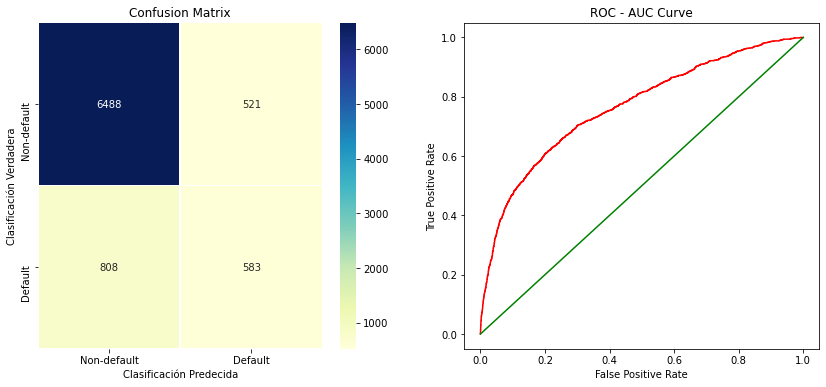

____________________________________________________________


In [19]:
param_rf = [
            {'criterion': 'entropy', 'max_depth': 9, 'max_features': 15, 'min_samples_leaf': 2, 'min_samples_split': 11, 'n_estimators': 179}
           ]
xtrain_data = X_SMOTE
ytrain_data = y_SMOTE

print('Utilizando SMOTE y los hiper parametros: ',param_rf[0])
model_eval(RandomForestClassifier(**param_rf[0],random_state= 42), xtrain_data,ytrain_data,X_test,y_test)
print("_" * 60)

Utilizando Random Forest con SMOTE e hiper parametros, se obtuvo una puntuación de prueba AUC de 0.76, una precisión de 0.84 y una puntuación de entrenamiento K-Fold de 0.88. Al ver los resultados, 7071 clientes fueron clasificados correctamente mientras que el restante 1329 no lo fue.

Se añaden los parametros al modelo.

In [20]:
param_r = {'criterion': 'entropy', 'max_depth': 9, 'max_features': 15, 'min_samples_leaf': 2, 'min_samples_split': 11, 'n_estimators': 179}
rfc_modelo = RandomForestClassifier(**param_r,random_state = 42).fit(X_SMOTE,y_SMOTE)

Se guarda el modelo para algún futuro uso.

In [21]:
# Guardando modelo
joblib.dump(rfc_modelo, "./random_forest_default_predictions")

['./random_forest_default_predictions']

Se consultan las caracteristicas más imporantes para el modelo.

In [22]:
def plot_Feature(feature, clf):
    tmp = pd.DataFrame({'Feature': feature, 
                        'Feature importance': clf.feature_importances_})
    tmp = tmp.sort_values(by='Feature importance',ascending=False)
    fig = go.Figure(go.Bar(
    x=tmp['Feature'],y=tmp['Feature importance'],marker={'color': tmp['Feature importance'], 
    'colorscale': 'Viridis'}
    ))
    fig.update_layout(title_text='Feature Importance',xaxis_title="Feature",yaxis_title="Importance")
    return fig.show()

plot_Feature(X_SMOTE.columns,rfc_modelo)

Al parecer las PAY_X fueron características bastantes importantes.

## 7. Estimación del Monto Total de la Cartera en Perdida

Para este proceso se creara un dataset con el nombre *validation_dataset.csv* con los datos de validación del modelo previamente armado. Se espera con este poder sumar la cantidad de deuda de cada cliente con una predicción a impagar y restarla con su respectiva suma de pago de deudas para obtener el monto total de la cartera perdida.

### 7.1 Creando el Dataset: *validation_dataset.csv*

Se unen X_test y y_test para crear este nuevo dataset.

In [23]:
df_test = X_test.join(y_test)

Se consulta el nuevo dataset para revisar que no tenga defectos.

In [24]:
df_test.head(3)

,LIMIT_BAL,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,...,EDUCATION_2,EDUCATION_3,EDUCATION_4,EDUCATION_5,EDUCATION_6,MARRIAGE_0,MARRIAGE_1,MARRIAGE_2,MARRIAGE_3,default
3031,110000,29,2,0,0,0,0,0,99876,72548,...,1,0,0,0,0,0,0,1,0,1
17829,300000,27,0,0,0,0,0,0,105786,113850,...,0,1,0,0,0,0,0,1,0,0
5765,80000,44,0,0,0,0,0,0,80610,81008,...,1,0,0,0,0,0,0,1,0,0


Se elimina la columna de impago ya que se tratará de predecir esta más adelante.

In [25]:
df_test = df_test.drop(columns='default')

Se crea un archivo .csv para guardar la información del dataset.

In [26]:
df_test.to_csv("validation_dataset.csv")
print("listo")

listo


### 7.2 Predicción y Probabilidad de Impago

Se cargan los datos del *validation_dataset.csv* a un dataframe.

In [27]:
df_validation = pd.read_csv("validation_dataset.csv")
print("listo")

listo


Se realizan algunos ajustes al Dataframe.

In [28]:
# Se elimina la primera columna ya que esta está formada por un indice el cual no se necesita
df_validation = df_validation.drop(df_validation.columns[0],axis=1)
df_validation.head(3)

,LIMIT_BAL,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,...,EDUCATION_1,EDUCATION_2,EDUCATION_3,EDUCATION_4,EDUCATION_5,EDUCATION_6,MARRIAGE_0,MARRIAGE_1,MARRIAGE_2,MARRIAGE_3
0,110000,29,2,0,0,0,0,0,99876,72548,...,0,1,0,0,0,0,0,0,1,0
1,300000,27,0,0,0,0,0,0,105786,113850,...,0,0,1,0,0,0,0,0,1,0
2,80000,44,0,0,0,0,0,0,80610,81008,...,0,1,0,0,0,0,0,0,1,0


Se consultan las dimensiones de este dataset.

In [29]:
print("validation_dataset -  filas:",df_validation.shape[0]," columnas:", df_validation.shape[1])

validation_dataset -  filas: 8400  columnas: 33


Se predice el valor binario de impago para cada cliente.

In [30]:
default = rfc_modelo.predict(df_validation)
print(default)

[1 0 0 ... 0 0 0]


Se consulta el porcentaje de certeza de cada predicción de impago por cliente.

In [31]:
porcentaje_de_certeza = rfc_modelo.predict_proba(df_validation)
print(porcentaje_de_certeza)

[[0.23939157 0.76060843]
 [0.86599665 0.13400335]
 [0.85165577 0.14834423]
 ...
 [0.82422896 0.17577104]
 [0.85724197 0.14275803]
 [0.63446001 0.36553999]]


Se completa el Dataframe con la información de predicción de impago y probabilidad de impago (PDI) de la predicción.

In [32]:
# Se agrega una columna con la información de predicción de impago por cliente
df_validation['impago'] = default

# Se selecciona el valor mas grande por fila del array de porcentajes de certeza
PDC = porcentaje_de_certeza[porcentaje_de_certeza == porcentaje_de_certeza.max(axis=1)[:,None]]
df_validation['PDI'] = PDC

df_validation.sample(3)

,LIMIT_BAL,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,...,EDUCATION_3,EDUCATION_4,EDUCATION_5,EDUCATION_6,MARRIAGE_0,MARRIAGE_1,MARRIAGE_2,MARRIAGE_3,impago,PDI
1783,230000,47,0,0,0,0,0,0,182787,173108,...,1,0,0,0,0,1,0,0,0,0.872496
1707,360000,40,1,-2,-2,-2,-2,-2,0,0,...,1,0,0,0,0,1,0,0,0,0.590141
3830,180000,36,-2,-2,-2,-2,-2,-2,2846,2092,...,0,0,0,0,0,1,0,0,0,0.829139


Se agrupan los clientes con impago.

In [33]:
clientes_con_impago = df_validation[(df_validation['impago']==1)]
clientes_con_impago.sample(3)

,LIMIT_BAL,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,...,EDUCATION_3,EDUCATION_4,EDUCATION_5,EDUCATION_6,MARRIAGE_0,MARRIAGE_1,MARRIAGE_2,MARRIAGE_3,impago,PDI
7455,80000,26,2,0,0,0,0,0,78768,79611,...,0,0,0,0,0,1,0,0,1,0.730156
51,120000,37,2,2,2,2,2,2,117681,119513,...,1,0,0,0,0,0,1,0,1,0.688612
5545,30000,26,2,2,2,2,2,2,200,200,...,0,0,0,0,0,0,1,0,1,0.721334


Se consulta la cantidad de clientes con impago.

In [34]:
print("clientes_con_impago -  filas:",clientes_con_impago.shape[0]," columnas:", clientes_con_impago.shape[1])

clientes_con_impago -  filas: 1104  columnas: 35


Asumiendo que las variables BILL_AMT son la cantidad a pagar y PAY_AMT la cantidad pagada hasta el momento por el cliente. Se procede a estimar el monto total de la cartera en perdida. 

In [35]:
clientes_con_impago["BILL_AMT_TOTAL"] = clientes_con_impago["BILL_AMT1"] + clientes_con_impago["BILL_AMT2"] + clientes_con_impago["BILL_AMT3"] + clientes_con_impago["BILL_AMT4"] + clientes_con_impago["BILL_AMT5"] + clientes_con_impago["BILL_AMT6"]

clientes_con_impago["PAY_AMT_TOTAL"] = clientes_con_impago["PAY_AMT1"] + clientes_con_impago["PAY_AMT2"] + clientes_con_impago["PAY_AMT3"] + clientes_con_impago["PAY_AMT4"] + clientes_con_impago["PAY_AMT5"] + clientes_con_impago["PAY_AMT6"]

clientes_con_impago["PERDIDA"] = clientes_con_impago["BILL_AMT_TOTAL"] - clientes_con_impago["PAY_AMT_TOTAL"]

Se consulta una vez más el dataframe para observar las columnas añadidas.

In [36]:
clientes_con_impago.sample(3)

,LIMIT_BAL,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,...,EDUCATION_6,MARRIAGE_0,MARRIAGE_1,MARRIAGE_2,MARRIAGE_3,impago,PDI,BILL_AMT_TOTAL,PAY_AMT_TOTAL,PERDIDA
3887,20000,49,1,2,3,2,0,0,18769,21349,...,0,0,1,0,0,1,0.573674,119888,3186,116702
4983,10000,27,2,0,0,0,0,0,6694,7546,...,0,0,0,1,0,1,0.793145,49184,3689,45495
3375,50000,31,1,1,-2,-2,-2,-2,43200,0,...,0,0,1,0,0,1,0.580651,43200,6000,37200


Se consulta una lista con los clientes predichos a impagar con su probabilidad de impago, suma total de deuda, suma total de cantidad pagada y la cantidad de perdida monetaria que representan cada uno para la compañía. Esto para propositos visuales.

In [37]:
clientes_con_impago[['impago', 'PDI', 'BILL_AMT_TOTAL',	'PAY_AMT_TOTAL', 'PERDIDA']]

,impago,PDI,BILL_AMT_TOTAL,PAY_AMT_TOTAL,PERDIDA
0,1,0.760608,481635,18500,463135
4,1,0.562064,192297,7000,185297
12,1,0.753720,1340664,53829,1286835
34,1,0.664253,419104,12800,406304
41,1,0.705122,145431,7300,138131
...,...,...,...,...,...
8354,1,0.590260,83469,6500,76969
8373,1,0.563293,120501,6174,114327
8384,1,0.531188,183506,6750,176756
8385,1,0.540488,261589,8400,253189


Por último, se estima la cantidad de perdida de dinero.

In [38]:
clientes_con_impago['PERDIDA'].sum()

319257409

Se estima que habría una perdida de <font size="5">$319,257,409.00</font> millones.

## 8. Conclusiones

Analicé las características sin tener un buen conocimiento del area, sino más bien lo que pude decifrar mediante el sentido común. Esta no es la forma correcta de proceder a trabajar los datos porque puede empujarme en la dirección equivocada y obtener resultados no suficientemente optimos.

Con más tiempo, me encantaría poder incluir lo siguiente para un mejor análisis en el futuro:
* Obtener diferentes conjuntos de datos, específicamente sobre la duración del historial bancario del cliente, ya que estos podrían contribuir en gran medida con más poder de predicción al modelo y agregarian más valor al dataset.
* Documentación de las variables. Al tener conocimiento del significado de las variables categoricas se puede obtener un mejor entendimiento de la demografía conociendo el género, título de educación, edad y estado civil para un análisis exploratorio más profundo.
* Agregar más filas de datos para optimizar el modelo.

Desde el punto de vista técnico, espero que este sea un buen punto de partida para un mejor modelo. Sé más sobre la construcción de modelos financieros que cuando empecé, y por lo tanto, esta prueba no solo sirvió para medir mis habilidades analíticas, sino tambien expandio mi conocimiento. 

Si se tiene alguna recomendación sobre cómo mejorar mi código o se ha notado que he pasado por alto algún aspecto importante del problema, agradecería si me se hiciera saber.